In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [2]:
%matplotlib notebook

In [3]:
g = 9.8
L1 = 1 
L2 = 1
m1 = 10
m2 = 10
ga = 2

In [4]:
def slope(t,y):
    c, s = np.cos(y[0]-y[2]), np.sin(y[0]-y[2])
    
    de = np.zeros_like(y)
    de[0] = y[1] #x1' = x2
    de[1] = (m2*g*np.sin(y[2])*c - m2*s*(L1*y[1]**2*c + L2*y[3]**2) - (m1 + m2)*g*np.sin(y[0]))/L1/(m1 + m2*s**2)
    de[2] = y[3] #y1' = y2
    de[3] = ((m1+m2)*(L1*y[1]**2*s - g*np.sin(y[2]) + g*np.sin(y[0])*c) + m2*L2*y[3]**2*s*c)/L2/(m1 + m2*s**2)
 
    return de

In [5]:
class func(nn.Module):
    def forward(self,t,u):
        y = u[0]
        c, s = np.cos(y[0]-y[2]), np.sin(y[0]-y[2])
    
        de = torch.zeros_like(y)
        de[0] = y[1] #x1' = x2
        de[1] = (m2*g*np.sin(y[2])*c - m2*s*(L1*y[1]**2*c + L2*y[3]**2) - (m1 + m2)*g*np.sin(y[0]))/L1/(m1 + m2*s**2)
        de[2] = y[3] #y1' = y2
        de[3] = ((m1+m2)*(L1*y[1]**2*s - g*np.sin(y[2]) + g*np.sin(y[0])*c) + m2*L2*y[3]**2*s*c)/L2/(m1 + m2*s**2)

        return de

In [6]:
tf = 30 #simulation for tf seconds
n = 2000 #number of evaluation points
dt = tf/n
T = np.linspace(0.0, tf, n+1)
t = torch.linspace(0.0, tf, n+1)

In [7]:
y0 = [np.pi/7, -1.0, 5*np.pi/4, 0.0]
y0T = torch.tensor([[np.pi, -1, 7*np.pi/8, -1]])

In [8]:
sol = solve_ivp(slope, (0,tf), y0, t_eval=T, method='RK45')
#solT = odeint(func(), y0T, t, method='adams')

In [9]:
theta1 = sol.y[0]
theta2 = sol.y[2]
#theta1 = solT.numpy()[:,0,0]
#theta2 = solT.numpy()[:,0,2]
x1_cor = 0
y1_cor = 1

In [10]:
x1 = L1 * np.sin(theta1) + x1_cor
y1 = -L1 * np.cos(theta1) + y1_cor
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

<IPython.core.display.Javascript object>


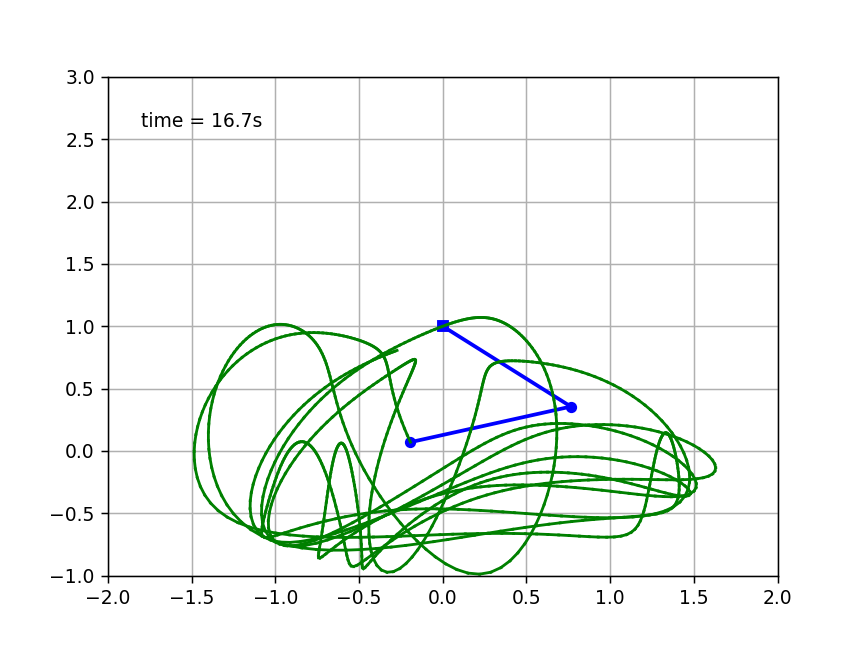

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2,2), ylim=(-1,3))
ax.grid()

#plot elements
anchor, = ax.plot([], [],'bs', markersize = 5)
line1, = ax.plot([], [],'b-', lw=2)
line2, = ax.plot([], [],'b-', lw=2)
mass1, = ax.plot([], [],'bo', markersize = m1/2)
mass2, = ax.plot([], [],'bo', markersize = m2/2)

time_template = 'time = '
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    anchor.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    mass1.set_data([], [])
    mass2.set_data([], [])

    time_text.set_text('')
    return anchor, line1, line2, mass1, mass2, time_text 

def animate(i):
    #path
    domain = [x2[i-1],x2[i]]
    ranges = [y2[i-1],y2[i]]
    plt.plot(domain,ranges,'g')
    
    #anchor
    anchor.set_data(x1_cor,y1_cor)
    #theta 1 pendulum
    thisx1 = [x1_cor, x1[i]] 
    thisy1 = [y1_cor, y1[i]]
    line1.set_data(thisx1, thisy1)
    #theta 2 pendulum
    thisx2 = [x1[i], x2[i]] 
    thisy2 = [y1[i], y2[i]] 
    line2.set_data(thisx2, thisy2)
    
    #masses
    mass1.set_data(x1[i],y1[i])
    mass2.set_data(x2[i],y2[i])
    
    
    time_text.set_text(time_template + '{:4.1f}'.format(i*dt) + 's')
    return anchor, line1, line2, mass1, mass2, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(T)),
                             interval=2, blit=True, init_func=init)
